In [1]:
import numpy as np
import pandas as pd
import gc
import pickle
import time

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [2]:
data = pd.read_pickle('matrix.pickle')
X_train = data[data.date_block_num < 33].drop(['date_block_num','item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['date_block_num','item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['date_block_num','item_cnt_month'], axis=1)
del data
gc.collect();

In [3]:
X_train.head()

,city_code,item_category_id,item_id,shop_id,subtype_code,type_code,month,item_shop_last_sale,item_last_sale,date_cat_avg_item_cnt_1,...,date_shop_avg_item_price_12,date_shop_subtype_avg_item_cnt_12,date_shop_sum_orders_12,date_shop_type_avg_item_cnt_12,item_cnt_month_12,item_price_12,orders_12,shop_item_avg_item_cnt_12,shop_item_avg_item_price_12,shop_item_sum_orders_12
4488710,0,19,27,2,10,5,1,1,1,1.181641,...,1071.0,0.515625,567.5,0.427002,1.0,2325.000000,1.0,0.125000,2.0,1340.000
4488711,0,40,30,2,4,11,1,1,1,0.309082,...,1665.0,0.000000,0.0,0.000000,0.0,299.000000,0.0,0.000000,3.0,0.000
4488712,0,37,31,2,1,11,1,1,1,0.234009,...,1665.0,0.000000,0.0,0.000000,0.0,299.000000,0.0,0.000000,3.0,0.000
4488713,0,40,32,2,4,11,1,999,1,0.309082,...,1071.0,0.073120,567.5,0.073853,0.0,338.110352,0.0,0.323486,11.0,199.500
4488714,0,37,33,2,1,11,1,1,1,0.234009,...,1071.0,0.085632,567.5,0.073853,1.0,488.517242,1.0,0.323486,11.0,240.875


In [4]:
ts = time.time()

m1 = XGBRegressor(
    max_depth=15,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    colsample_bylevel=0.8, 
    subsample=0.8, 
    eta=0.3, 
    num_round=1000,
    seed=1, 
    nthread=24)

m1.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.14103	validation_1-rmse:1.10946
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08445	validation_1-rmse:1.06536
[2]	validation_0-rmse:1.03552	validation_1-rmse:1.03168
[3]	validation_0-rmse:0.993616	validation_1-rmse:1.00678
[4]	validation_0-rmse:0.960171	validation_1-rmse:0.983175
[5]	validation_0-rmse:0.930818	validation_1-rmse:0.964232
[6]	validation_0-rmse:0.903003	validation_1-rmse:0.948147
[7]	validation_0-rmse:0.879072	validation_1-rmse:0.936673
[8]	validation_0-rmse:0.859051	validation_1-rmse:0.92616
[9]	validation_0-rmse:0.841547	validation_1-rmse:0.917487
[10]	validation_0-rmse:0.827305	validation_1-rmse:0.91113
[11]	validation_0-rmse:0.814529	validation_1-rmse:0.907281
[12]	validation_0-rmse:0.803612	validation_1-rmse:0.903336
[13]	validation_0-rmse:0.793812	validation_1-rmse:0.901193
[14]	validation_0-rmse:0.785649	va

36878.0106985569

In [5]:
pickle.dump(m1, open("m1.pickle.dat", "wb"))
#m1 = pickle.load(open("m1.pickle.dat", "rb"))

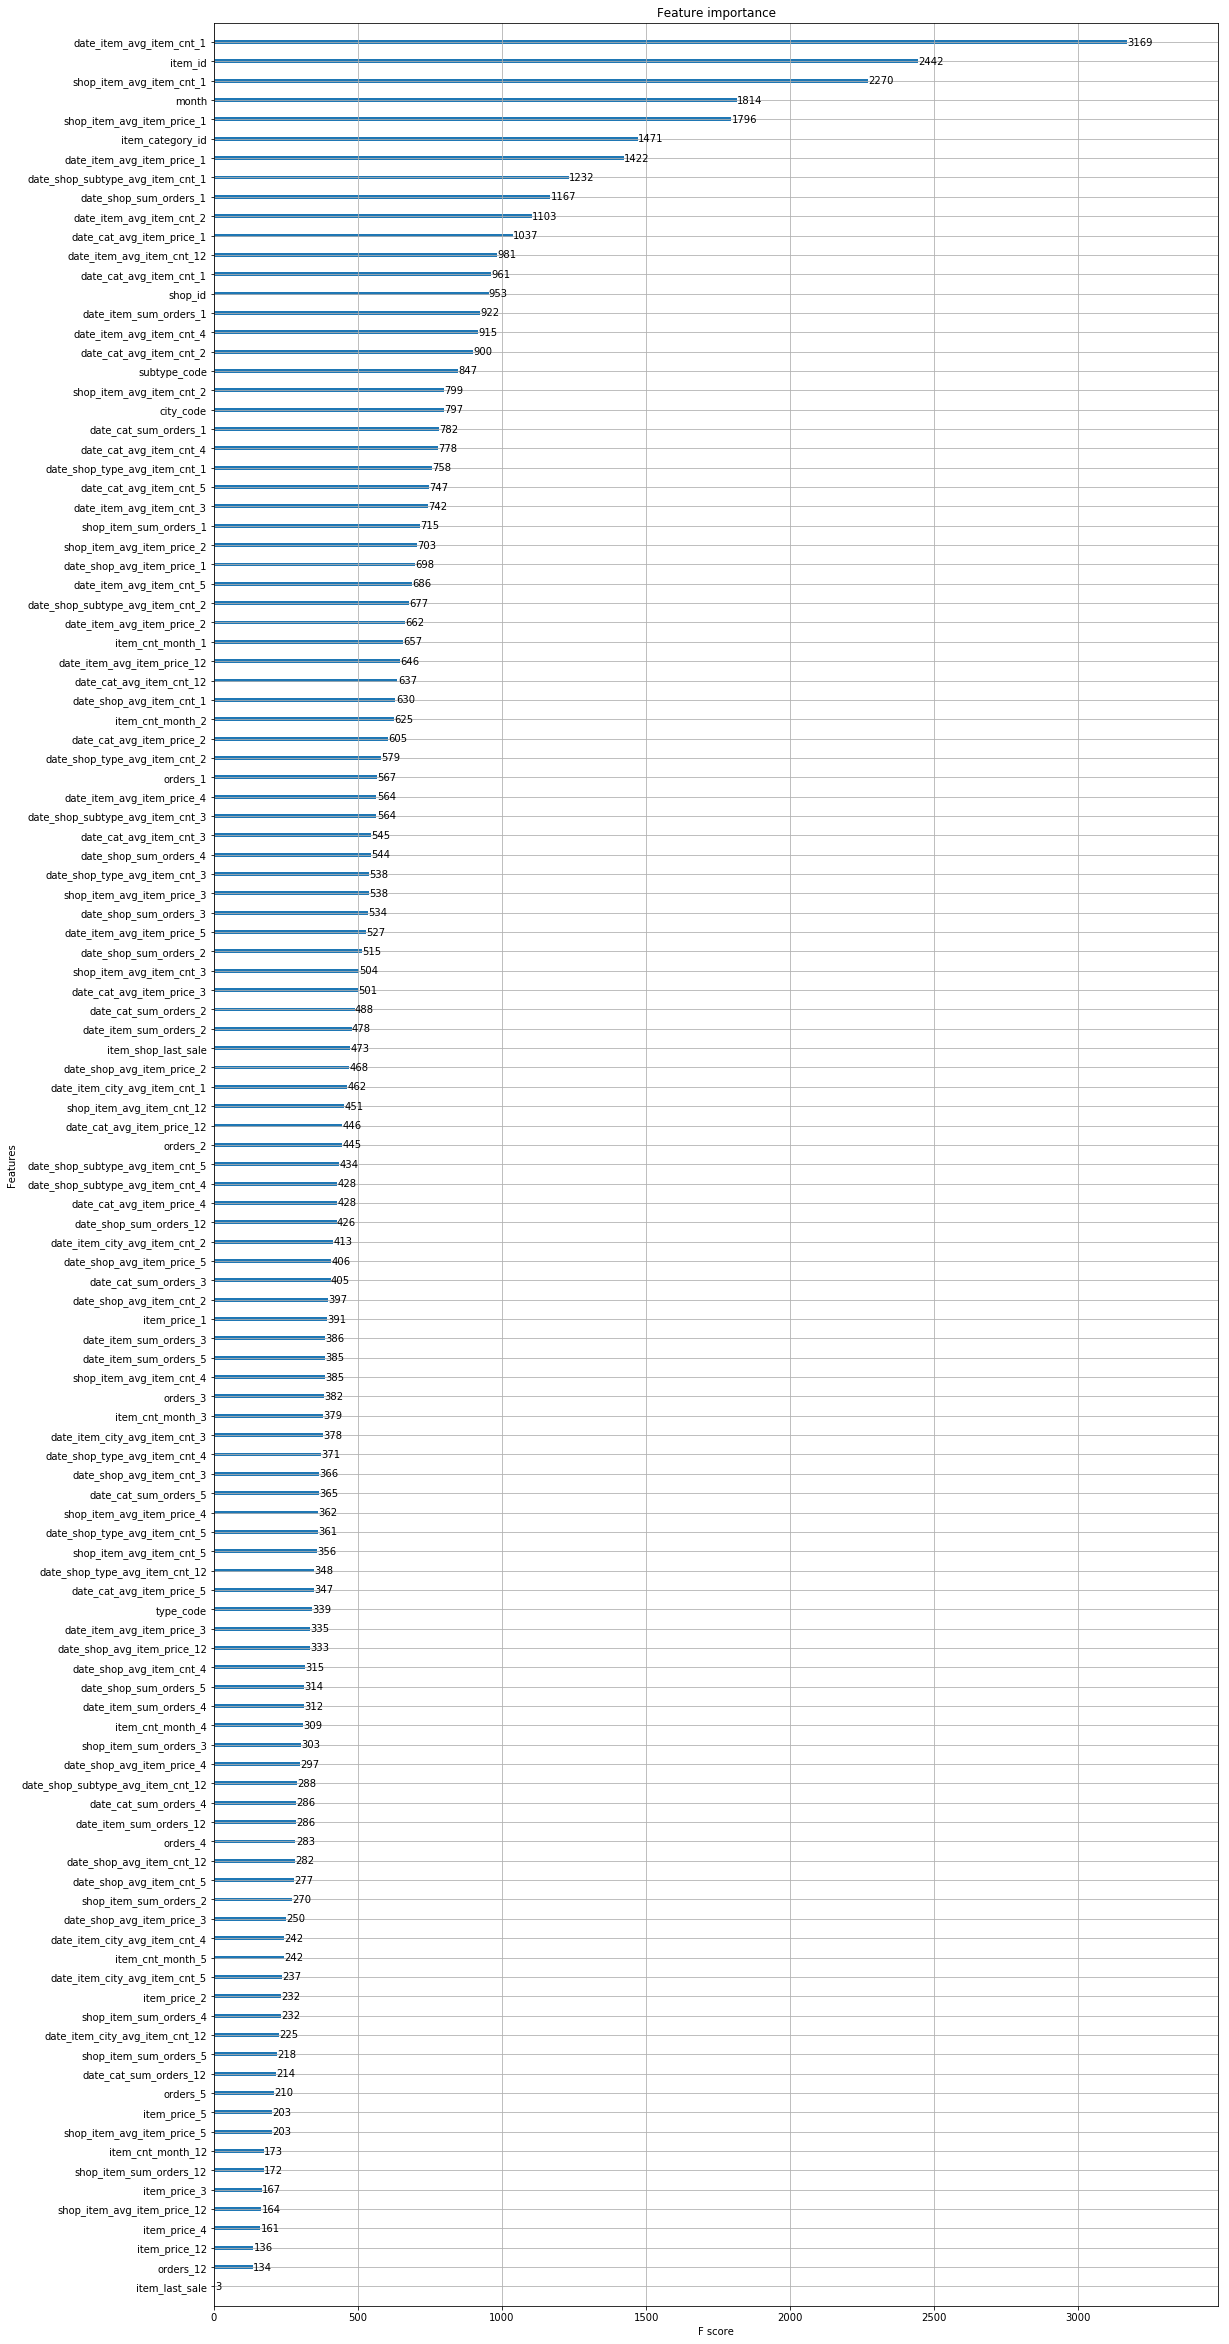

In [6]:
plot_features(m1, (18,42))

In [7]:
Y_test = m1.predict(X_test).clip(0, 20)

test = pd.read_csv('test.csv.gz', compression='gzip').set_index('ID')
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

LB: 0.97157